In [74]:
%run "setup.py"

In [5]:
con = psycopg2.connect(database=os.environ['VN_ORMA_DB_DB'], user=os.environ['VN_ORMA_DB_USER'], password=os.environ['VN_ORMA_DB_PASS'], host=os.environ['VN_ORMA_DB_HOST'])

In [6]:
def bytea2bytes(value, cur):
    m = psycopg2.BINARY(value, cur)
    if m is not None:
        return m.tobytes()

BYTEA2BYTES = psycopg2.extensions.new_type(
    psycopg2.BINARY.values, 'BYTEA2BYTES', bytea2bytes)
psycopg2.extensions.register_type(BYTEA2BYTES)

# REF DATA

In [7]:
%%time
sql = '''SELECT way_id, st_asBinary(geom) AS geom, district, province, "length" from lines_with_admin where length>0'''
ways_by_region = pd.read_sql(sql, con)

CPU times: user 1.01 s, sys: 742 ms, total: 1.75 s
Wall time: 29.6 s


In [8]:
%%time
ways_by_region.geom = ways_by_region.geom.apply(shapely.wkb.loads)
ways_by_region.columns = ['way_id','geom', 'district_id', 'province_id', "length"]

CPU times: user 2.48 s, sys: 102 ms, total: 2.59 s
Wall time: 2.67 s


In [9]:
%%time
ways_by_region = ways_by_region.assign(way_id_district='')
ways_by_region['way_id_district']=ways_by_region['way_id'].astype(str)+'_'+ways_by_region['district_id'].astype(str)
# ways_by_region = ways_by_region[ways_by_region['length']>0.025] #Lets only get stretches longer than 25 meters
ways_by_region.head()

CPU times: user 325 ms, sys: 6.64 ms, total: 331 ms
Wall time: 415 ms


,way_id,geom,district_id,province_id,length,way_id_district
0,621459,"LINESTRING (107.6846456 16.1100207, 107.684588...",544,535,0.006727,621459_544
1,621460,"LINESTRING (107.6293901 16.1321231, 107.629531...",544,535,0.015087,621460_544
2,621461,"LINESTRING (107.6896599 16.1193368, 107.688849...",544,535,0.425995,621461_544
3,621462,"LINESTRING (107.6762691 16.132847, 107.6770147...",544,535,0.552539,621462_544
4,621463,"LINESTRING (107.6796343 16.1321115, 107.679410...",544,535,0.367059,621463_544


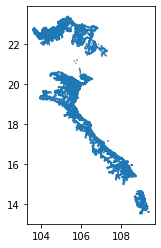

In [19]:
gdf = gpd.GeoDataFrame(ways_by_region, geometry='geom')
gdf.plot()
plt.show()

In [20]:
bacme = ways_by_region.loc[ways_by_region.district_id==301, :]

In [21]:
bacme.length.sum()

437.8930737039552

## Region IDs

In [22]:
sql = 'select id, "type", name_en, name_vn from admin_boundaries'
admin_names = pd.read_sql(sql, con)
admin_names.set_index(['id'], inplace=True)

districts = admin_names[admin_names.type=='district'][['name_vn']]
districts.columns=['district']

provinces = admin_names[admin_names.type=='province'][['name_vn']]
provinces.columns=['province']

In [23]:
admin_names[admin_names.name_en=='Bac Me']

,type,name_en,name_vn
id,,,
301,district,Bac Me,Huyện Bắc Mê


In [24]:
sorted(districts.district.tolist())

['Huyện A Lưới',
 'Huyện An Biên',
 'Huyện An Dương',
 'Huyện An Lão',
 'Huyện An Lão',
 'Huyện An Minh',
 'Huyện An Phú',
 'Huyện Anh Sơn',
 'Huyện Ba Bể',
 'Huyện Ba Chẽ',
 'Huyện Ba Tri',
 'Huyện Ba Tơ',
 'Huyện Ba Vì',
 'Huyện Buôn Đôn',
 'Huyện Bàu Bàng',
 'Huyện Bá Thước',
 'Huyện Bác Ái',
 'Huyện Bát Xát',
 'Huyện Bình Chánh',
 'Huyện Bình Gia',
 'Huyện Bình Giang',
 'Huyện Bình Liêu',
 'Huyện Bình Lục',
 'Huyện Bình Sơn',
 'Huyện Bình Tân',
 'Huyện Bình Xuyên',
 'Huyện Bình Đại',
 'Huyện Bù Gia Mập',
 'Huyện Bù Đăng',
 'Huyện Bù Đốp',
 'Huyện Bạch Long Vĩ',
 'Huyện Bạch Thông',
 'Huyện Bảo Lâm',
 'Huyện Bảo Lâm',
 'Huyện Bảo Lạc',
 'Huyện Bảo Thắng',
 'Huyện Bảo Yên',
 'Huyện Bắc Bình',
 'Huyện Bắc Hà',
 'Huyện Bắc Mê',
 'Huyện Bắc Quang',
 'Huyện Bắc Sơn',
 'Huyện Bắc Trà My',
 'Huyện Bắc Tân Uyên',
 'Huyện Bắc Yên',
 'Huyện Bến Cầu',
 'Huyện Bến Lức',
 'Huyện Bố Trạch',
 'Huyện Cai Lậy',
 'Huyện Cam Lâm',
 'Huyện Cam Lộ',
 'Huyện Can Lộc',
 'Huyện Cao Lãnh',
 'Huyện Cao Lộc',

## current way tags

In [25]:
%%time
sql = "select * from current_way_tags"
way_tags_raw = pd.read_sql(sql, con)

CPU times: user 300 ms, sys: 134 ms, total: 434 ms
Wall time: 6.54 s


In [26]:
way_tags = way_tags_raw.pivot(index='way_id', columns='k', values='v').reset_index()
way_tags.drop(['province', 'addr:district', 'addr:province'], axis=1, inplace=True)

## Road properties

In [27]:
sql = "select * from road_properties where properties != '{}'"
road_properties_raw = pd.read_sql(sql, con)

In [28]:
road_properties = json_normalize(road_properties_raw['properties'].to_list())
all_cols = list(road_properties.columns)

new_headers = {}
inversed_headers = {}
for col in all_cols:
    normalized = col.strip().lower()
    if normalized in inversed_headers.keys():
        fltr = ~road_properties[col].isna()
        road_properties.loc[fltr, inversed_headers[normalized]] = road_properties.loc[fltr, col]
        continue
    inversed_headers[normalized] = col
    new_headers[col] = normalized
road_properties = road_properties[list(new_headers.keys())]
road_properties.columns = [new_headers[x] for x in road_properties.columns]

road_properties = road_properties.assign(iri=road_properties.iri_med)
road_properties.loc[road_properties.iri.isna(),'iri'] = road_properties.loc[road_properties.iri.isna(),'iri_mean']
road_properties.loc[road_properties.iri.isna(),'iri'] = road_properties.loc[road_properties.iri.isna(),'iri_max']
road_properties.loc[road_properties.iri.isna(),'iri'] = road_properties.loc[road_properties.iri.isna(),'iri_min']
columns_of_interest = ['length','road name', 'management', 'road end location', 'road start location', 'road number', 'iri', 'road width']
road_properties = road_properties[columns_of_interest]
road_properties = road_properties_raw[['id']].join(road_properties)
road_properties.drop(['length'], axis=1, inplace=True)

In [29]:
road_properties.head()

,id,road name,management,road end location,road start location,road number,iri,road width
0,674XT00085,Đường xã Xuân Kiên,4,Xóm 12B (giáp Xuân Tiến),Cầu đường 489C (xóm 14),NaN,NaN,NaN
1,034YM00181,Đường đến thôn Nà Mòn,NaN,NaN,NaN,ĐX.164,NaN,NaN
2,313HN00013,Bồng Sơn - Hoài Hương,3,Hoài Hương,Bồng Sơn,,NaN,NaN
3,034YM00216,Đường đi nhóm hộ thôn Phiêng Kiền,NaN,NaN,NaN,ĐX.199,NaN,NaN
4,673YY00017,57B - Yên Lộc,3,UBND xã Yên Lộc,Đường 57B,,NaN,NaN


## Old data

In [37]:
ronet_data = pd.read_csv('../data/Traffic_mockup.csv')

In [38]:
ronet_data.head()

,VPROMM_ID,OLD_traffic_level,OLD_WIDTH,OLD_CLASS,OLD_SURFACE,OLD_CONDITION
0,032HG00001,3,3.5,6,3,3
1,032HG00002,3,5.5,4,3,3
2,032HG00002,3,3.5,6,3,4
3,032HG00003,3,3.5,6,3,3
4,032HG00003,3,3.5,6,3,3


# Data fusion

In [39]:
def x0(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[0][0]
def x1(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[0][-1]
def y0(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[1][0]
def y1(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[1][-1]

In [40]:
%%time
merged_data = ways_by_region.merge(districts, how='left',left_on='district_id', right_on='id')
merged_data = merged_data.merge(provinces, how='left',left_on='province_id', right_on='id')
merged_data.drop(['district_id', 'province_id'], axis=1, inplace=True)
merged_data = merged_data.merge(way_tags, on='way_id', how='left')
merged_data = merged_data.merge(road_properties, how='left', left_on='or_vpromms', right_on='id')
merged_data = merged_data.assign(empty= '', aadt=0, x_0= merged_data.geom.apply(x0), x_1= merged_data.geom.apply(x1), y_0= merged_data.geom.apply(y0), y_1= merged_data.geom.apply(y1))
merged_data.columns = [x[3:] if x[:3]=='or_' else x for x in merged_data.columns]
ways_by_region.shape[0], merged_data.shape[0]

CPU times: user 29.8 s, sys: 796 ms, total: 30.6 s
Wall time: 32.2 s


(220860, 220860)

In [41]:
%%time
merged_data = merged_data.merge(ronet_data, left_on='vpromms', right_on='VPROMM_ID', how='left')

# For now let's just make it easy and get the first element that got matched with our IDs
merged_data.drop_duplicates(['way_id_district'], inplace=True)

CPU times: user 581 ms, sys: 252 ms, total: 833 ms
Wall time: 1.05 s


In [42]:
labeled_data = merged_data

In [43]:
np.sum(labeled_data[~labeled_data.vpromms.isna()]['length']), np.sum(labeled_data['length'])

(11512.535028690792, 75966.14303768275)

### Merges data on equivalent fields

In [44]:
field_pairs = [['name', 'road name'], ['width', 'section_carraigeway'], ['width', 'road width'], ['condition', 'section_pavement_condition'], ['width', 'OLD_WIDTH'], ['section_traffic', 'OLD_traffic_level'], ['link_class', 'OLD_CLASS'], ['section_surface', 'OLD_SURFACE'], ['condition', 'OLD_CONDITION']]

for fld, alt_fld in field_pairs:
    merged_data.loc[merged_data[fld].isna(), fld] = merged_data.loc[merged_data[fld].isna(), alt_fld]

### Fixes data types

In [45]:
labeled_data.loc[:, ' '] = labeled_data.section_carraigeway.str.replace(",", ".").astype(float)
labeled_data.loc[~labeled_data['section_pavement'].isna(), 'section_pavement'] = labeled_data.loc[~labeled_data['section_pavement'].isna(), 'section_pavement'].str[-1]
# labeled_data.loc[~labeled_data['section_surface'].isna(), 'section_surface'] = labeled_data.loc[~labeled_data['section_surface'].isna(), 'section_surface'].str[0]
labeled_data.loc[~labeled_data['section_pavement_condition'].isna(), 'section_pavement_condition'] = labeled_data.loc[~labeled_data['section_pavement_condition'].isna(), 'section_pavement_condition'].str[0]

traffic_fields = ['section_motorcycle', 'section_small_car', 'section_medium_car', 'section_delivery_vehicle', 'section_light_truck', 
                  'section_medium_truck', 'section_heavy_truck', 'section_articulated_truck', 'section_small_bus', 'section_medium_bus', 'section_large_bus']
    
tot = np.zeros(labeled_data.shape[0])
for field in traffic_fields:
    labeled_data[field].fillna(0, inplace=True)
    labeled_data.loc[~labeled_data[field].apply(lambda x: str(x).isnumeric()), field] = 0 
    labeled_data.loc[:, field] = labeled_data[field].astype(float)
    tot += labeled_data[field].values
labeled_data.loc[:, 'aadt'] = tot


for x in [1, 2, 3]:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '1'
    
for x in [4, 5]:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '2'
    
for x in ['concrete', 'asphalt', 'paved', 'concrete:lanes', 'Concrete']:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '1'

for x in ['ground', 'unpaved', 'earth']:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '2'

for x in ['concrete', 'concrete:lanes', 'Concrete']:
    labeled_data.loc[(labeled_data['surface'] == x) & (labeled_data.section_surface.isna()), 'section_surface'] = '1'
    
for x in ['asphalt']:
    labeled_data.loc[(labeled_data['surface'] == x) & (labeled_data.section_surface.isna()), 'section_surface'] = '2'
    
for x in ['earth']:
    labeled_data.loc[(labeled_data['surface'] == x) & (labeled_data.section_surface.isna()), 'section_surface'] = '5'
    
    
for i, cl in enumerate(['Class I','Class II','Class III','Class IV','Class V','Class VI','A','B','C','D']):
    labeled_data.loc[labeled_data['link_class'].str.lower() == cl.lower(), 'link_class'] = i + 1
    
for i, cl in enumerate(['Very Good', 'Good', 'Fair', 'Poor', 'Very Poor']):
    labeled_data.loc[labeled_data['condition'].str.lower() == cl.lower(), 'condition'] = i + 1
labeled_data.loc[labeled_data['condition'].str.lower() =='bad', 'condition'] = 4

### Creates outputs

In [46]:
ha_giang = labeled_data[labeled_data.province=='Hà Giang']
filtered = ha_giang[(~ha_giang.section_lanes.isna())|(~ha_giang.width.isna())]

filtered = filtered[~filtered.link_class.isna()]
# filtered = filtered[~filtered.section_temperature.isna()]
# filtered = filtered[~filtered.section_moisture.isna()]
# filtered = filtered[~filtered.section_traffic_growth.isna()]

# filtered = filtered[~filtered.section_terrain.isna()]
filtered.loc[filtered.section_moisture.isna(), 'section_terrain'] = '3'

filtered = filtered[(~filtered.condition.isna())|(~filtered.iri.isna())]

filtered = filtered[(~filtered.surface.isna())|(~filtered.section_surface.isna())]

filtered = filtered[filtered.section_traffic.astype(float)>0]

# # BECAUSE WE KNOW IT IS HUMID AND HOT
filtered.loc[filtered.section_moisture.isna(), 'section_moisture'] = 4
filtered.loc[filtered.section_temperature.isna(), 'section_temperature'] = 1

# And let's assume traffic growth will be medium, or everything drops out
filtered.loc[filtered.section_traffic_growth.isna(), 'section_traffic_growth'] = 3

In [47]:
zero_for_now = ['section_motorcycle', 'section_small_car', 'section_medium_car', 'section_four_wheel', 'section_delivery_vehicle', 'section_light_truck', 'section_medium_truck', 'section_heavy_truck', 'section_articulated_truck', 'section_small_bus', 'section_medium_bus', 'section_large_bus', 'aadt']
for col in zero_for_now:
    filtered.loc[:, col] = np.nan

In [48]:
cba_column_order = ['VPROMM_ID','way_id_district', 
                    'road number', 'name', 'road start location', 'road end location', 
                    'empty', 'empty', 'province', 'district', 'section_commune_gso', 'management', 'empty', 'empty', 'x_0', 'y_0', 'x_1', 'y_1', 
                    'length', 'section_lanes', 'width', 'empty', 'empty', 'link_class', 'section_terrain', 'section_temperature', 'section_moisture', 'surface', 'section_surface',
                    'empty', 'empty', 'empty',
                    'condition', 'iri', 'empty', 'empty', 'empty', 'section_pavement_age', 'empty',
                    'section_traffic', 'section_motorcycle', 'section_small_car', 'section_medium_car', 'section_four_wheel', 'section_delivery_vehicle', 'section_light_truck', 'section_medium_truck', 'section_heavy_truck', 'section_articulated_truck', 'section_small_bus', 'section_medium_bus', 'section_large_bus', 'aadt','section_traffic_growth'
                ]

In [49]:
data = filtered[cba_column_order]
data.to_csv('../data/segments_generated.csv', index=False)

In [50]:
gdf_cols = [x for x in cba_column_order if x != 'empty']
data = filtered[gdf_cols]
geo = filtered.geom[~data.x_0.isna()]
data = data[~data.x_0.isna()]

gdf = gpd.GeoDataFrame(data, geometry=geo)
gdf = gdf.set_crs(4326)
gdf.to_file('../data/sections_generated.gpkg', driver="GPKG", encoding='utf-8')

In [121]:
# data = {}
# ha_giang = labeled_data[labeled_data.province=='Hà Giang']
# # ha_giang = labeled_data
# data['total_length'] = ha_giang['length'].sum()
# data['length_with_VPROMM'] = ha_giang[~ha_giang.vpromms.isna()]['length'].sum()
# data['with_link_class'] = ha_giang[(~ha_giang.link_class.isna())]['length'].sum()
# data['with_terrain_type'] = ha_giang[(~ha_giang.section_terrain.isna())]['length'].sum()
# data['lanes_or_width'] = ha_giang[(~ha_giang.section_lanes.isna())|(~ha_giang.width.isna())]['length'].sum()
# data['pavement_condition'] = ha_giang[(~ha_giang.condition.isna())|(~ha_giang.section_surface.isna())]['length'].sum()
# data['pavement_type'] = ha_giang[(~ha_giang.section_pavement.isna())|(~ha_giang.section_surface.isna())]['length'].sum()
# data['aadt_or_traffic_intensity'] = ha_giang[(ha_giang.aadt.astype(float)>0)|(ha_giang.section_traffic.astype(float)>0)]['length'].sum()


# for k, v in data.items():
#     print(f'{k},{round(v, 2)}')

total_length,4861.28
length_with_VPROMM,3834.88
with_link_class,3123.05
with_terrain_type,988.84
lanes_or_width,3189.31
pavement_condition,3195.51
pavement_type,3115.45
aadt_or_traffic_intensity,3600.38


In [69]:
#example_data = pd.read_excel('../data/2019 RoADS CBA Version 1.00 2019-09-25_EXAMPLE.xlsm', sheet_name="RoADS Sections Data and Results", header=29, usecols=list(range(1,54)))
example_data.query('RoadSectionID == "635950_304"')
# pd.read_excel('../data/2019 RoADS CBA Version 1.00 2019-05-25_EXAMPLE.xlsm')

,RoadSectionID,RoadNumber,RoadName,RoadStart,RoadEnd,SectionOrder,SectionName,Province,District,Commune,...,AADT_4Wheel,AADT_SmallTruck,AADT_MediumTruck,AADT_LargeTruck,AADT_ArticulatedTruck,AADT_SmallBus,AADT_MediumBus,AADT_LargeBus,AADT_Total,TrafficGrowth
58,635950_304,ÄH.01,Quang Minh-VÃ´ Äiáº¿m-Báº±ng HÃ nh,QL279 (Km0+660),QL 279 (Km20+800),NaN,NaN,HÃ Giang,Huyá»‡n Báº¯c Quang,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [117]:
from section import Section
from cba_result import CbaResult

def default_int(a_string: str):
    return 0 if a_string == "" else int(a_string)

def default_float(a_string: str, a_float=0.0):
    return 0.0 if a_string == "" else float(a_string)

def section_from_row(row):
    row = row.fillna('')
    data = {'orma_way_id': row['way_id_district'], 
            'vpromm_id' : row['VPROMM_ID'], 
            'section_id' : row['road number'], 
            'road_number' : row['road number'], 
            'road_name' : row['name'], 
            'road_start' : row['road start location'], 
            'road_end' : row['road end location'],
            'province' : row['province'],
            'district' : row['district'],
            'commune' : row['section_commune_gso'], 
            'management' : row['management'], 
            'start_km' : row['x_0'], 
            'end_km' : row['x_1'], 
            'length' : row['length'], 
            'lanes' : row['section_lanes'], 
            'width' : row['width'], 
            'road_class' : row['link_class'], 
            'terrain' : row['section_terrain'], 
            'temperature' : row['section_temperature'], 
            'moisture' : row['section_moisture'], 
            'surface_type' : row['surface'], 
            'condition_class' : row['condition'], 
            'roughness' : default_float(row['iri']), 
            'traffic_level' : row['section_traffic'], 
            'traffic_growth' : row['section_traffic_growth'],  
            'pavement_age' : row['section_pavement_age'], 
            'aadt_motorcyle' : default_int(row['section_motorcycle']), 
            'aadt_carsmall' : default_int(row['section_small_car']), 
            'aadt_carmedium' : default_int(row['section_medium_car']), 
            'aadt_delivery' : default_int(row['section_delivery_vehicle']), 
            'aadt_4wheel' : default_int(row['section_four_wheel']), 
            'aadt_smalltruck' : default_int(row['section_light_truck']), 
            'aadt_mediumtruck' : default_int(row['section_medium_truck']), 
            'aadt_largetruck' : default_int(row['section_heavy_truck']), 
            'aadt_articulatedtruck' : default_int(row['section_articulated_truck']), 
            'aadt_smallbus' : default_int(row['section_small_bus']), 
            'aadt_mediumbus' : default_int(row['section_medium_bus']), 
            'aadt_largebus' : default_int(row['section_large_bus']), 
                                          'aadt_total' : default_int(row['aadt'])
            # 'structural_no' : row[''], 'road_type' : row[''], 
           }  
    return Section(data)

tmp = data.query('way_id_district == "635950_304"').apply(section_from_row, axis=1)
s = list(tmp)[0]

import json
with open("../tests/example_data/section_635950_304.json", 'w') as f:
    f.write(json.dumps(s.to_primitive(), indent=2))